In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

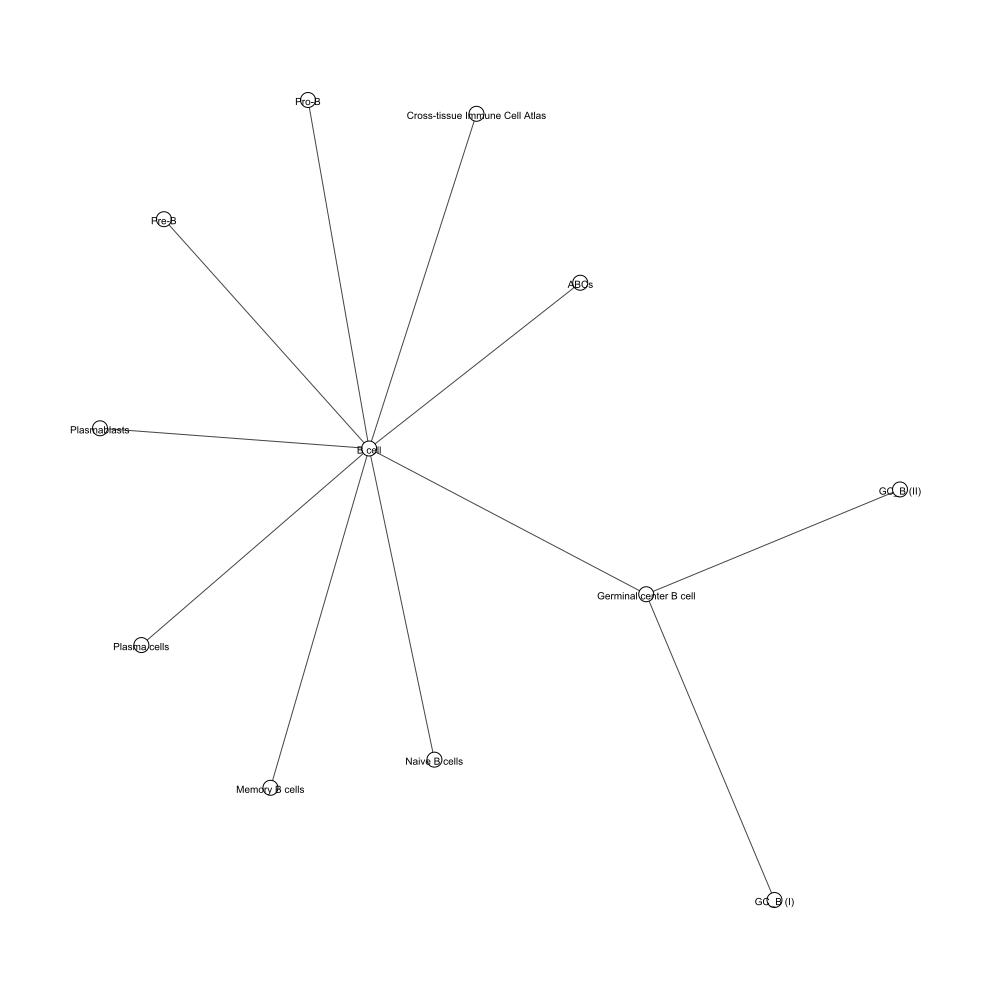

In [2]:
dataset = sc.read('b-cells.h5ad')

list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_ct)) 
dataset = dataset[dataset.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}

g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])

# g.write('tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

In [3]:
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1

dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

D = dist_df
D = torch.tensor(D.values, dtype=float)

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

In [5]:
embdeding_dim = 8

def train(mode, loss_mode, epochs=30, cuda=1):
    D_metric = D.cuda()
    if mode == 'Net':
        model = Net(mode, 128, 32, len(list_ct)).cuda()
    elif mode == 'Proto_Net':
        model = Net(mode, 128, 32, embdeding_dim).cuda()
        model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=embdeding_dim, device='cuda').cuda()
    elif mode == 'VAE':
        model_vae = vanilla_vae.VanillaVAE(128, embdeding_dim, [64]).cuda()
        model = prototypical_network.LearntPrototypes(model_vae, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=embdeding_dim, device='cuda', mode=mode).cuda()
    criterion = nn.CrossEntropyLoss()
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            elif mode == 'VAE':
                out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = 2 * xe_loss
            if 'pl' in loss_mode:
                pl_loss = PL(centers = model.prototypes.data)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss
            if 'vae' in loss_mode:
                vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
                loss = loss + vae_loss['loss']/10
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            elif mode == 'VAE':
                with torch.no_grad():
                    out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model):
    y_test = dataset[test_indices].obs['Manually_curated_celltype']
    if mode == 'Net':
        y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'Proto_Net':
        y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'VAE':
        y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

In [7]:
# mode in ['Net', 'Proto_Net', 'VAE']
mode = ''
# loss_mode in ['pl', 'disto', 'vae']
loss_mode = ''

Epoch 1
Train ER 30.94, time 1.7s
Test ER 6.33, time 0.1s
Epoch 2
Train ER 5.50, time 0.3s
Test ER 4.71, time 0.0s
Epoch 3
Train ER 4.31, time 0.3s
Test ER 3.97, time 0.0s
Epoch 4
Train ER 3.90, time 0.3s
Test ER 3.83, time 0.0s
Epoch 5
Train ER 3.79, time 0.3s
Test ER 3.83, time 0.1s
Epoch 6
Train ER 3.65, time 0.3s
Test ER 3.80, time 0.0s
Epoch 7
Train ER 3.58, time 0.3s
Test ER 3.69, time 0.0s
Epoch 8
Train ER 3.57, time 0.3s
Test ER 3.70, time 0.0s
Epoch 9
Train ER 3.51, time 0.3s
Test ER 3.61, time 0.1s
Epoch 10
Train ER 3.51, time 0.3s
Test ER 3.64, time 0.0s
Epoch 11
Train ER 3.47, time 0.4s
Test ER 3.62, time 0.0s
Epoch 12
Train ER 3.45, time 0.3s
Test ER 3.55, time 0.0s
Epoch 13
Train ER 3.40, time 0.4s
Test ER 3.61, time 0.0s
Epoch 14
Train ER 3.41, time 0.3s
Test ER 3.67, time 0.0s
Epoch 15
Train ER 3.37, time 0.3s
Test ER 3.70, time 0.0s
Epoch 16
Train ER 3.35, time 0.3s
Test ER 3.62, time 0.0s
Epoch 17
Train ER 3.35, time 0.4s
Test ER 3.62, time 0.0s
Epoch 18
Train ER 3.28

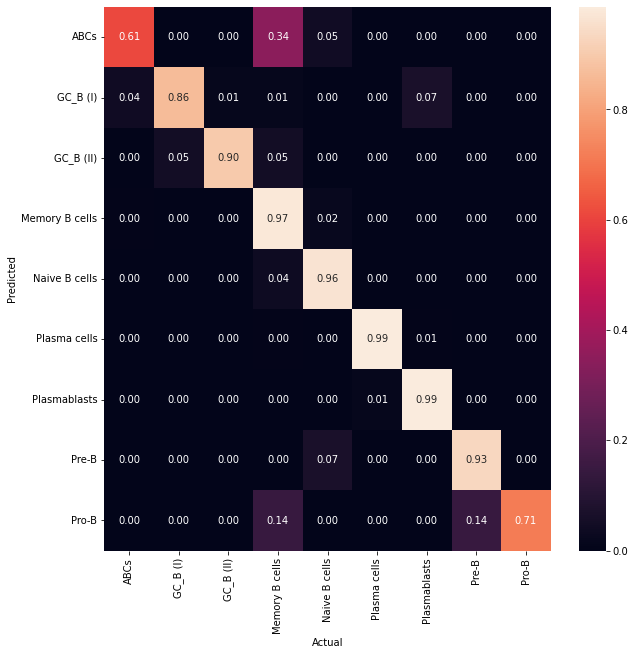

In [8]:
# Only Neural Network
mode = 'Net'
loss_mode = ''
model = train(mode=mode, loss_mode=loss_mode)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 44.76, time 0.7s
Test ER 8.00, time 0.1s
Epoch 2
Train ER 6.00, time 0.6s
Test ER 5.50, time 0.1s
Epoch 3
Train ER 5.29, time 0.6s
Test ER 5.12, time 0.1s
Epoch 4
Train ER 4.59, time 0.6s
Test ER 4.44, time 0.1s
Epoch 5
Train ER 4.18, time 0.6s
Test ER 4.12, time 0.1s
Epoch 6
Train ER 4.06, time 0.6s
Test ER 3.93, time 0.1s
Epoch 7
Train ER 3.94, time 0.6s
Test ER 3.98, time 0.1s
Epoch 8
Train ER 3.84, time 0.5s
Test ER 3.88, time 0.1s
Epoch 9
Train ER 3.73, time 0.6s
Test ER 3.73, time 0.1s
Epoch 10
Train ER 3.67, time 0.5s
Test ER 3.87, time 0.1s
Epoch 11
Train ER 3.67, time 0.6s
Test ER 3.76, time 0.1s
Epoch 12
Train ER 3.62, time 0.5s
Test ER 3.74, time 0.1s
Epoch 13
Train ER 3.58, time 0.6s
Test ER 3.69, time 0.1s
Epoch 14
Train ER 3.57, time 0.6s
Test ER 3.75, time 0.1s
Epoch 15
Train ER 3.50, time 0.6s
Test ER 3.72, time 0.1s
Epoch 16
Train ER 3.51, time 0.5s
Test ER 3.63, time 0.1s
Epoch 17
Train ER 3.49, time 0.6s
Test ER 3.67, time 0.1s
Epoch 18
Train ER 3.45

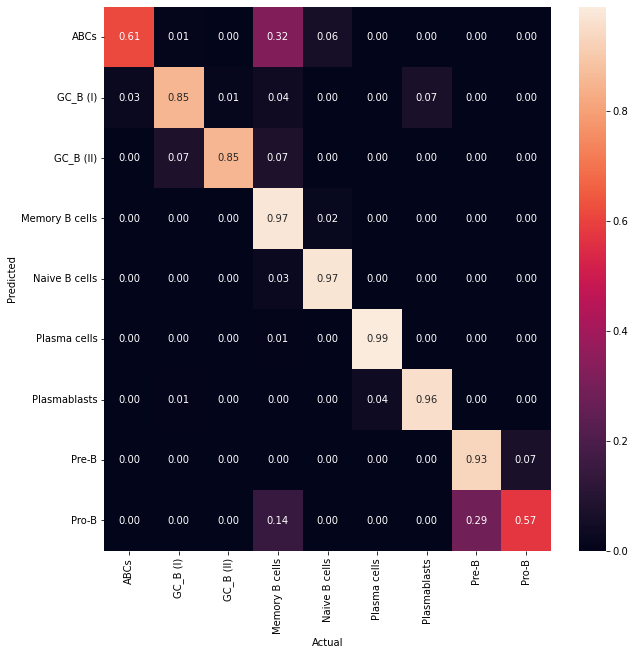

In [9]:
mode='Proto_Net'
loss_mode='disto'
model = train(mode=mode, loss_mode=loss_mode)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 16.77, time 0.7s
Test ER 6.07, time 0.1s
Epoch 2
Train ER 6.04, time 0.6s
Test ER 5.82, time 0.1s
Epoch 3
Train ER 5.79, time 0.7s
Test ER 5.33, time 0.1s
Epoch 4
Train ER 5.28, time 0.6s
Test ER 5.14, time 0.1s
Epoch 5
Train ER 5.12, time 0.7s
Test ER 5.04, time 0.1s
Epoch 6
Train ER 4.71, time 0.6s
Test ER 4.53, time 0.1s
Epoch 7
Train ER 4.43, time 0.7s
Test ER 4.29, time 0.1s
Epoch 8
Train ER 4.30, time 0.6s
Test ER 4.26, time 0.1s
Epoch 9
Train ER 4.22, time 0.7s
Test ER 4.14, time 0.1s
Epoch 10
Train ER 4.14, time 0.6s
Test ER 4.14, time 0.1s
Epoch 11
Train ER 4.09, time 0.6s
Test ER 4.07, time 0.1s
Epoch 12
Train ER 4.06, time 0.6s
Test ER 4.09, time 0.1s
Epoch 13
Train ER 4.02, time 0.7s
Test ER 4.14, time 0.1s
Epoch 14
Train ER 4.01, time 0.6s
Test ER 4.09, time 0.1s
Epoch 15
Train ER 3.96, time 0.7s
Test ER 4.11, time 0.1s
Epoch 16
Train ER 3.97, time 0.6s
Test ER 4.09, time 0.1s
Epoch 17
Train ER 3.92, time 0.7s
Test ER 4.09, time 0.1s
Epoch 18
Train ER 3.91

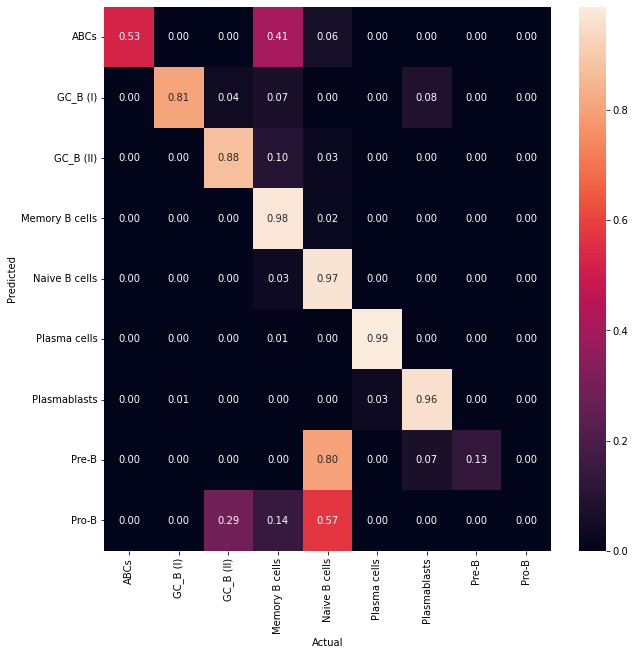

In [10]:
mode='Proto_Net'
loss_mode='disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 75.89, time 1.0s
Test ER 44.71, time 0.1s
Epoch 2
Train ER 31.33, time 0.8s
Test ER 19.78, time 0.1s
Epoch 3
Train ER 14.65, time 0.9s
Test ER 11.03, time 0.1s
Epoch 4
Train ER 10.31, time 0.9s
Test ER 9.54, time 0.1s
Epoch 5
Train ER 9.04, time 0.9s
Test ER 8.77, time 0.1s
Epoch 6
Train ER 8.39, time 0.8s
Test ER 7.96, time 0.1s
Epoch 7
Train ER 8.05, time 0.9s
Test ER 7.77, time 0.1s
Epoch 8
Train ER 7.63, time 0.8s
Test ER 7.27, time 0.1s
Epoch 9
Train ER 7.45, time 0.9s
Test ER 7.08, time 0.1s
Epoch 10
Train ER 7.17, time 0.9s
Test ER 7.09, time 0.1s
Epoch 11
Train ER 7.03, time 1.0s
Test ER 7.10, time 0.1s
Epoch 12
Train ER 6.99, time 1.1s
Test ER 6.87, time 0.1s
Epoch 13
Train ER 6.91, time 0.9s
Test ER 6.56, time 0.1s
Epoch 14
Train ER 6.82, time 0.9s
Test ER 6.67, time 0.1s
Epoch 15
Train ER 6.70, time 0.9s
Test ER 6.33, time 0.1s
Epoch 16
Train ER 6.65, time 0.8s
Test ER 6.66, time 0.1s
Epoch 17
Train ER 6.64, time 0.9s
Test ER 6.87, time 0.1s
Epoch 18
Train E

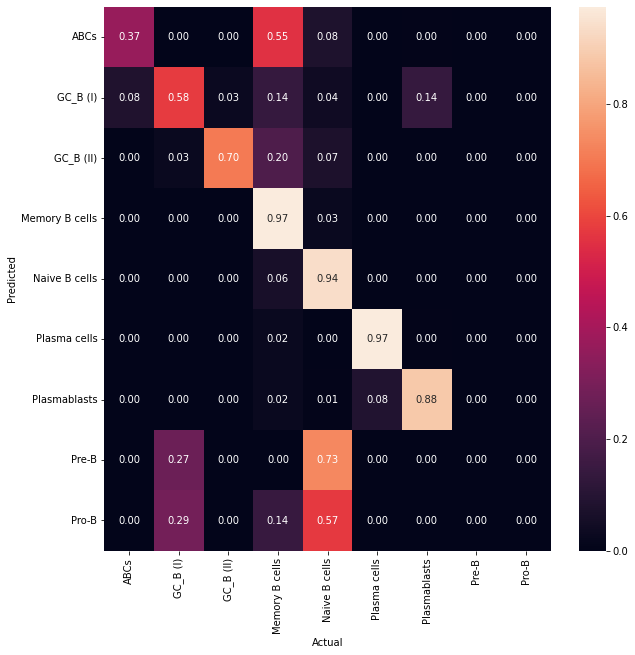

In [11]:
mode='VAE'
loss_mode='vae'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 38.10, time 1.0s
Test ER 13.97, time 0.1s
Epoch 2
Train ER 10.80, time 1.0s
Test ER 9.29, time 0.1s
Epoch 3
Train ER 8.66, time 1.0s
Test ER 8.16, time 0.1s
Epoch 4
Train ER 7.83, time 1.0s
Test ER 7.19, time 0.1s
Epoch 5
Train ER 7.45, time 1.0s
Test ER 6.94, time 0.1s
Epoch 6
Train ER 6.94, time 1.1s
Test ER 6.71, time 0.1s
Epoch 7
Train ER 6.68, time 1.0s
Test ER 6.55, time 0.1s
Epoch 8
Train ER 6.34, time 1.1s
Test ER 6.18, time 0.1s
Epoch 9
Train ER 6.24, time 1.0s
Test ER 5.88, time 0.1s
Epoch 10
Train ER 6.09, time 1.1s
Test ER 5.86, time 0.1s
Epoch 11
Train ER 5.86, time 1.0s
Test ER 5.92, time 0.1s
Epoch 12
Train ER 5.89, time 1.1s
Test ER 5.70, time 0.1s
Epoch 13
Train ER 5.73, time 1.1s
Test ER 5.72, time 0.1s
Epoch 14
Train ER 5.75, time 1.1s
Test ER 5.64, time 0.1s
Epoch 15
Train ER 5.61, time 1.0s
Test ER 5.45, time 0.1s
Epoch 16
Train ER 5.58, time 1.0s
Test ER 5.65, time 0.1s
Epoch 17
Train ER 5.49, time 1.0s
Test ER 5.41, time 0.1s
Epoch 18
Train ER 5.

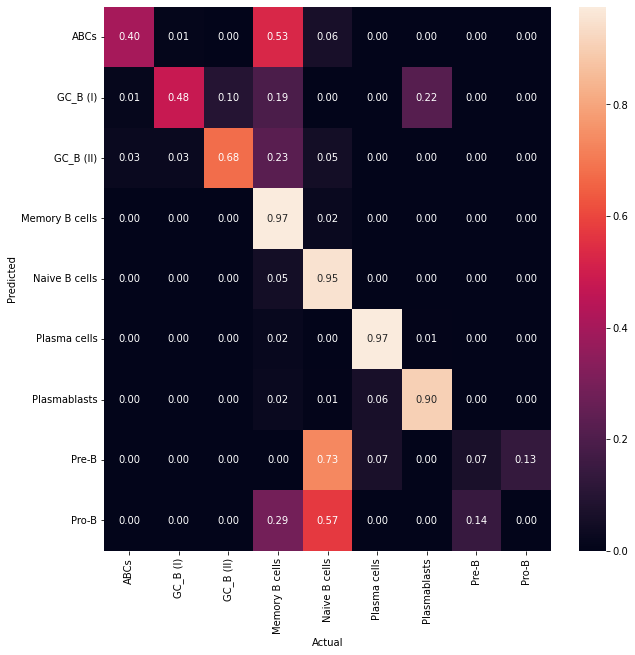

In [12]:
mode='VAE'
loss_mode='vae_disto'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 91.19, time 0.9s
Test ER 88.12, time 0.1s
Epoch 2
Train ER 75.24, time 1.0s
Test ER 61.74, time 0.1s
Epoch 3
Train ER 52.37, time 0.9s
Test ER 41.84, time 0.1s
Epoch 4
Train ER 32.40, time 1.0s
Test ER 22.98, time 0.1s
Epoch 5
Train ER 18.57, time 0.9s
Test ER 14.33, time 0.1s
Epoch 6
Train ER 12.24, time 1.0s
Test ER 10.07, time 0.1s
Epoch 7
Train ER 9.10, time 0.9s
Test ER 8.21, time 0.1s
Epoch 8
Train ER 7.87, time 1.0s
Test ER 7.44, time 0.1s
Epoch 9
Train ER 7.35, time 0.9s
Test ER 6.90, time 0.1s
Epoch 10
Train ER 7.07, time 1.0s
Test ER 6.93, time 0.1s
Epoch 11
Train ER 6.76, time 0.9s
Test ER 6.73, time 0.1s
Epoch 12
Train ER 6.63, time 1.0s
Test ER 6.54, time 0.1s
Epoch 13
Train ER 6.62, time 0.9s
Test ER 6.59, time 0.1s
Epoch 14
Train ER 6.47, time 1.1s
Test ER 6.38, time 0.1s
Epoch 15
Train ER 6.31, time 1.0s
Test ER 6.46, time 0.1s
Epoch 16
Train ER 6.32, time 1.0s
Test ER 6.23, time 0.1s
Epoch 17
Train ER 6.31, time 0.9s
Test ER 6.30, time 0.1s
Epoch 18
Tr

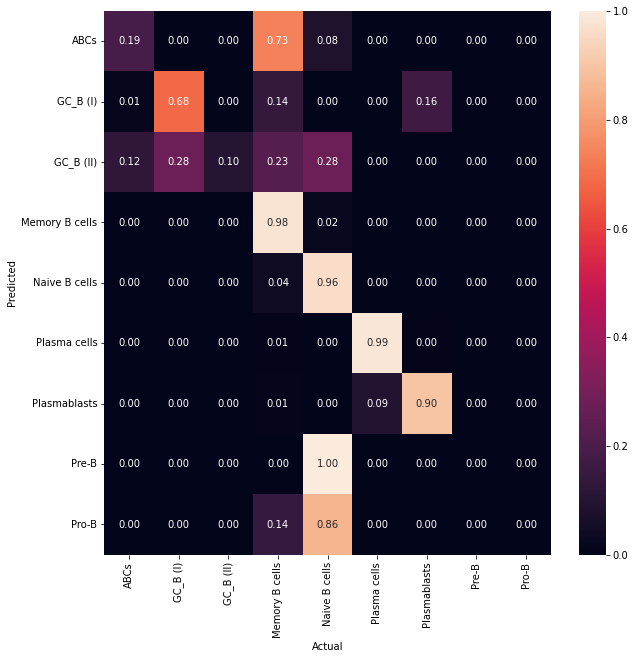

In [13]:
mode='VAE'
loss_mode='vae_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 76.81, time 1.1s
Test ER 53.34, time 0.1s
Epoch 2
Train ER 44.97, time 1.1s
Test ER 35.98, time 0.1s
Epoch 3
Train ER 27.63, time 1.1s
Test ER 19.49, time 0.1s
Epoch 4
Train ER 15.65, time 1.1s
Test ER 12.39, time 0.1s
Epoch 5
Train ER 10.86, time 1.1s
Test ER 9.09, time 0.1s
Epoch 6
Train ER 8.56, time 1.1s
Test ER 7.79, time 0.1s
Epoch 7
Train ER 7.54, time 1.2s
Test ER 7.00, time 0.1s
Epoch 8
Train ER 7.18, time 1.0s
Test ER 6.88, time 0.1s
Epoch 9
Train ER 6.81, time 1.1s
Test ER 6.49, time 0.1s
Epoch 10
Train ER 6.63, time 1.0s
Test ER 6.56, time 0.1s
Epoch 11
Train ER 6.51, time 1.2s
Test ER 6.48, time 0.1s
Epoch 12
Train ER 6.38, time 1.1s
Test ER 6.34, time 0.1s
Epoch 13
Train ER 6.38, time 1.2s
Test ER 6.20, time 0.1s
Epoch 14
Train ER 6.21, time 1.0s
Test ER 6.21, time 0.1s
Epoch 15
Train ER 6.21, time 1.1s
Test ER 6.25, time 0.1s
Epoch 16
Train ER 6.11, time 1.0s
Test ER 5.93, time 0.1s
Epoch 17
Train ER 6.04, time 1.1s
Test ER 5.89, time 0.1s
Epoch 18
Train

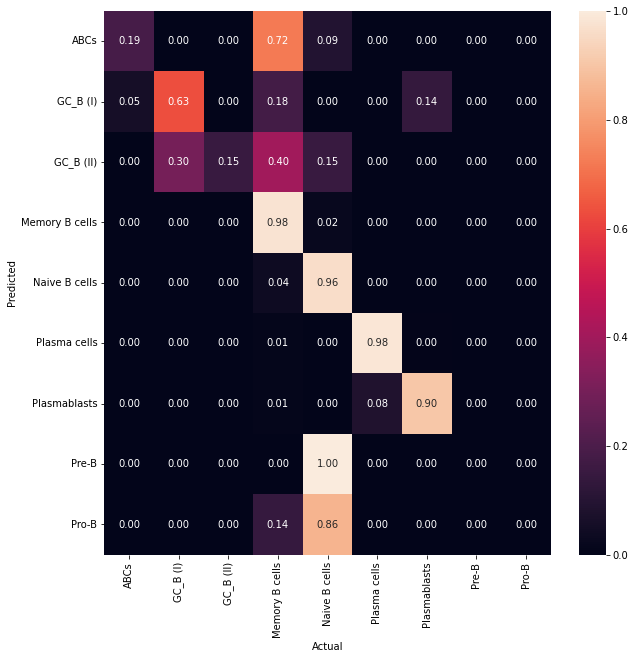

In [14]:
mode='VAE'
loss_mode='vae_disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

In [15]:
ids = []
for cell_type in encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))):
    indices = np.where(dataset.obs['Manually_curated_celltype'] == cell_type)[0]
    ids.append(len(indices))

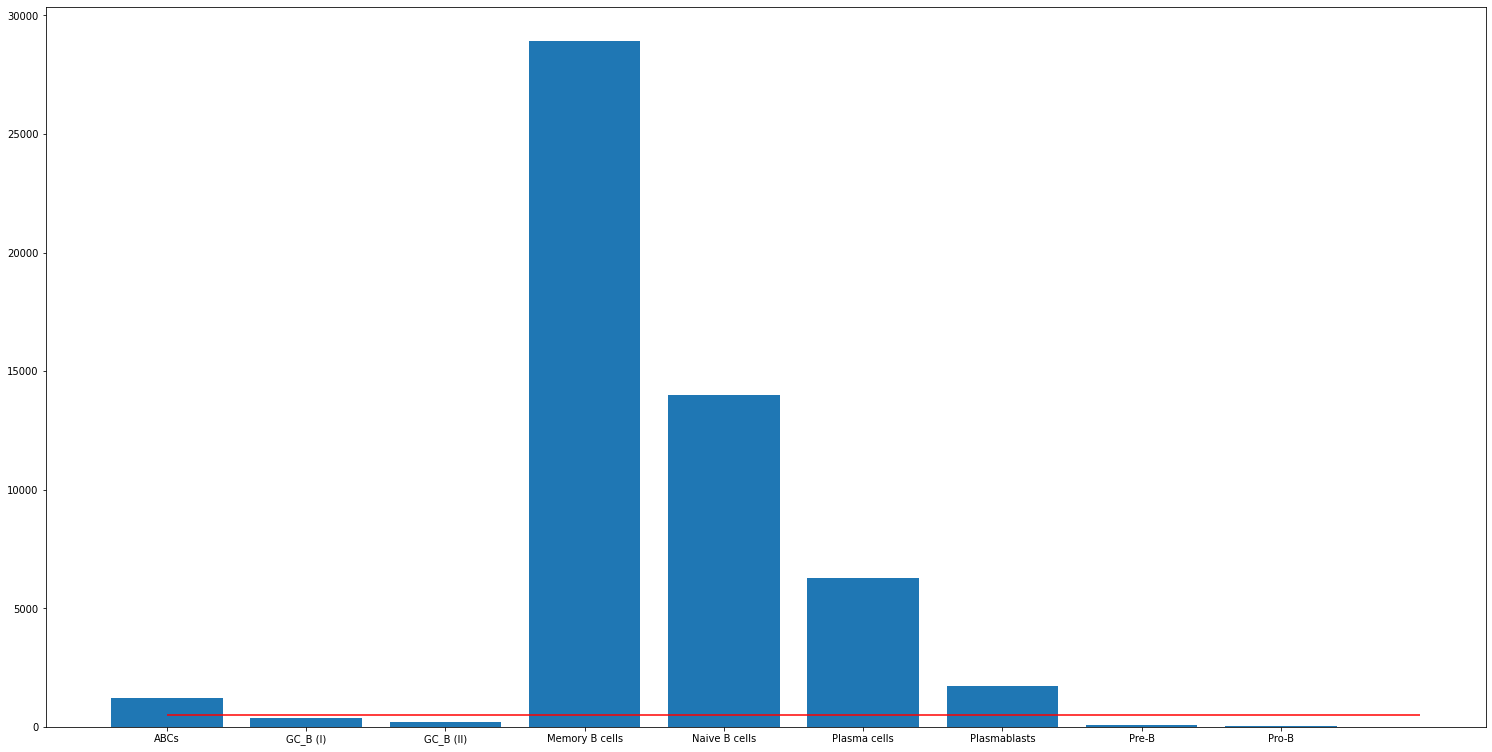

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist())))
students = ids
ax.bar(langs, students)
ax.hlines(500, 0, len(dataset.obs['Manually_curated_celltype'].unique().tolist()), color='r')
fig.set_size_inches(20,10)
plt.show()